# 3D Cardiac Segmentation with TransUNet

In [1]:
!nvidia-smi

Wed Nov 16 02:17:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    14W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup environment

In [2]:
# mount driver
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg/TransUNet/CHGH

# install dependents
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q timm
!pip install -U -q openmim
!mim install -U -q mmcv-full
!pip install ml-collections
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1jz_DGnICBmKWCr_JL904PDQdIEK0_EQG/CardiacSeg/TransUNet/CHGH
     |████████████████████████████████| 1.2 MB 31.2 MB/s 
     |████████████████████████████████| 41 kB 573 kB/s 
     |████████████████████████████████| 548 kB 25.7 MB/s 
     |████████████████████████████████| 163 kB 63.7 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 237 kB 52.9 MB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 
     |████████████████████████████████| 43.7 MB 12.3 MB/s 
     |████████████████████████████████| 190 kB 31.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.9 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=4cb186c5f64f94a91b2bb2e94369def06063e7893d91ea2acc3c52f886e428ab
  Stored in directory: /root/.cache/p

In [3]:
import os

exp_name = 'exp_1_2_2d'
root_dir = '/content/drive/MyDrive/CardiacSeg/TransUNet/CHGH'

model_name = 'transunet'
data_dir = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1_2d'
data_dict_dir = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH'
model_dir = os.path.join(root_dir, 'models', exp_name)
log_dir = os.path.join(root_dir, 'logs', exp_name)
eval_dir = os.path.join(root_dir, 'evals', exp_name)
start_epoch = 0
val_every = 20
max_epoch = 2000
pin_memory = True
test_mode = False
best_checkpoint = os.path.join(model_dir, 'best_model.pth')
final_checkpoint = os.path.join(model_dir, 'final_model.pth')
data_dicts_json = os.path.join(data_dict_dir, 'data_dicts', f'{exp_name}.json')

In [ ]:
!python /content/drive/MyDrive/CardiacSeg/expers/chgh/train_2d.py \
--model_name={model_name} \
--data_dir={data_dir} \
--model_dir={model_dir} \
--log_dir={log_dir} \
--eval_dir={eval_dir} \
--start_epoch=0 \
--val_every=20 \
--max_epoch=4000 \
--optim_lr=1e-4 \
--pin_memory \
--data_dicts_json={data_dicts_json} \
#--checkpoint={final_checkpoint}

2022-11-14 15:04:17,885 - Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
2022-11-14 15:04:17,906 - Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
/usr/local/lib/python3.7/dist-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
cuda is available
load json from /content/drive/MyDrive/CardiacSeg/dataset/CHGH/data_dicts/exp_1_2_2d.json
/usr/local/lib/python3.7/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use Me

# debug

## Lib

In [ ]:
import sys

# set package path
sys.path.append("/content/drive/MyDrive/CardiacSeg")

import argparse
import os
from functools import partial
from pathlib import PurePath

from PIL import Image
import pandas as pd
import numpy as np

from tqdm import tqdm

import torch
from torch.utils.tensorboard import SummaryWriter

from monai.inferers import SliceInferer
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandSpatialCropSamplesd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    ScaleIntensityd,
    Spacingd,
    RandRotate90d,
    RandSpatialCropd,
    SqueezeDimd,
    SaveImaged,
    ToTensord
)

from data_utils.io import load_json
from data_utils.data_loader import MyDataLoader, get_dl, split_data_dicts
from data_utils.chgh_dataset_2d import get_loader
from data_utils import chgh_dataset as chgh_ds
from data_utils.utils import get_pids_by_loader, get_pid_by_file
from runners.trainer import run_training
from runners.tester import run_testing
from networks.network import network
from optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

/usr/local/lib/python3.7/dist-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


## Config

In [ ]:
parser = argparse.ArgumentParser(description="model segmentation pipeline")

# mode
parser.add_argument("--test_mode", action="store_true", help="test mode")

# dir and path
parser.add_argument("--data_dir", default="", type=str, help="dataset directory")
parser.add_argument("--model_dir", default="models", type=str, help="directory to save the models")
parser.add_argument("--log_dir", default="logs", type=str, help="directory to save the tensorboard logs")
parser.add_argument("--eval_dir", default="evals", type=str, help="directory to save the eval result")
parser.add_argument("--checkpoint", default=None, help="start training from saved checkpoint")
parser.add_argument("--filename", default="best_model.pth", help="save model file name")

# train loop
parser.add_argument("--start_epoch", default=0, type=int, help="start epoch")
parser.add_argument("--val_every", default=10, type=int, help="validation frequency")
parser.add_argument("--max_epoch", default=2000, type=int, help="max number of training epochs")
parser.add_argument("--early_stop_count", default=0, type=int, help="early stop count")
parser.add_argument("--max_early_stop_count", default=10, type=int, help="max early stop count")
parser.add_argument("--save_checkpoint_freq", default=1, type=int, help="save final checkpoint freq, if value is 0 won't save.")

# data
parser.add_argument("--data_dicts_json", default=None, type=str, help="data dicts json")
parser.add_argument("--fold", default=1, type=int, help="index of fold")
parser.add_argument("--split_train_ratio", default=0.6, type=float, help="split train ratio")
parser.add_argument("--num_fold", default=2, type=int, help="num fold")
parser.add_argument("--batch_size", default=2, type=int, help="number of batch size")
parser.add_argument("--val_batch_size", default=1, type=int, help="number of batch size")
parser.add_argument("--pin_memory", action="store_true", help="pin memory")
parser.add_argument("--workers", default=2, type=int, help="number of workers")

# transform
parser.add_argument("--num_samples", default=2, type=int, help="number of samples")
parser.add_argument("--a_min", default=-175.0, type=float, help="a_min in ScaleIntensityRanged")
parser.add_argument("--a_max", default=250.0, type=float, help="a_max in ScaleIntensityRanged")
parser.add_argument("--b_min", default=0.0, type=float, help="b_min in ScaleIntensityRanged")
parser.add_argument("--b_max", default=1.0, type=float, help="b_max in ScaleIntensityRanged")
parser.add_argument("--space_x", default=0.7, type=float, help="spacing in x direction")
parser.add_argument("--space_y", default=0.7, type=float, help="spacing in y direction")
parser.add_argument("--space_z", default=1.0, type=float, help="spacing in z direction")
parser.add_argument("--roi_x", default=96, type=int, help="roi size in x direction")
parser.add_argument("--roi_y", default=96, type=int, help="roi size in y direction")
parser.add_argument("--roi_z", default=96, type=int, help="roi size in z direction")
parser.add_argument("--rand_flipd_prob", default=0.1, type=float, help="RandFlipd aug probability")
parser.add_argument("--rand_rotate90d_prob", default=0.1, type=float, help="RandRotate90d aug probability")
parser.add_argument("--rand_shift_intensityd_prob", default=0.1, type=float, help="RandShiftIntensityd aug probability")

# model
parser.add_argument("--model_name", default=None, type=str, help="model name")
parser.add_argument("--in_channels", default=1, type=int, help="number of input channels")
parser.add_argument("--out_channels", default=2, type=int, help="number of output channels")

# optimizer
parser.add_argument("--optim_lr", default=1e-4, type=float, help="optimization learning rate")
parser.add_argument("--reg_weight", default=1e-5, type=float, help="regularization weight")

# scheduler
parser.add_argument("--lrschedule", default=None, type=str, help="type of learning rate scheduler")
parser.add_argument("--warmup_epochs", default=50, type=int, help="number of warmup epochs")

# infer
parser.add_argument("--sw_batch_size", default=1, type=int, help="number of sliding window batch size")
parser.add_argument("--infer_overlap", default=0.25, type=float, help="sliding window inference overlap")

args = parser.parse_args([])

args.model_name=model_name
args.data_dir=data_dir
args.model_dir=model_dir
args.log_dir=log_dir
args.eval_dir=eval_dir
args.start_epoch=0
args.val_every=10
args.max_epoch=4000
args.pin_memory=True
args.optim_lr=1e-4
args.data_dicts_json=data_dicts_json

# make dir
os.makedirs(args.model_dir, exist_ok=True)
os.makedirs(args.log_dir, exist_ok=True)
os.makedirs(args.eval_dir, exist_ok=True)

# device
if torch.cuda.is_available():
    print("cuda is available")
    args.device = torch.device("cuda")
else:
    print("cuda is not available")
    args.device = torch.device("cpu")

cuda is available


## Preporcess

### build 2d dataset

In [ ]:
# from data_utils.preprocess import build_2d_dataset
# from transforms.chgh_transform_2d import get_val_transform

# src_data_dir = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1'
# dst_data_dir = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1_2d'

# transform = get_val_transform(args)
# data_dcits = chgh_ds.get_data_dicts(src_data_dir)
# build_2d_dataset(data_dcits, dst_data_dir, transform)

/usr/local/lib/python3.7/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


pid_06


117it [00:01, 79.23it/s]


pid_08


171it [04:50,  1.70s/it]


pid_27


166it [00:02, 77.92it/s]


pid_57


165it [00:02, 69.93it/s]


pid_106


162it [04:30,  1.67s/it]


pid_107


151it [00:01, 80.05it/s]


pid_108


134it [00:01, 81.68it/s]


pid_110


147it [04:03,  1.66s/it]


pid_1000


143it [03:58,  1.67s/it]


pid_1001


139it [03:41,  1.60s/it]


### generat data ditcs json

In [ ]:
# from data_utils.chgh_dataset_2d import gen_data_dicts_json_2d

# pids = [27, 57, 107, 108, 106, 1000]
# pid_dirs = list(map(lambda x: f'pid_{x:02d}', pids))

# data_dir = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1'
# data_dir_2d = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset_1_2d'
# gen_data_dicts_json_2d(
#     data_dir, 
#     data_dir_2d,
#     data_dicts_json, 
#     args.fold, 
#     args.num_fold, 
#     args.split_train_ratio, 
#     pid_dirs=pid_dirs
# )

train data: ['pid_27', 'pid_57']
val data: ['pid_107', 'pid_108']
test data: ['pid_106', 'pid_1000']
save json to /content/drive/MyDrive/CardiacSeg/dataset/CHGH/data_dicts/exp_1_2_2d.json


## DL

In [ ]:
from data_utils.visualization import show_img_lbl
from monai.utils import set_determinism
import matplotlib.pyplot as plt
set_determinism(seed=0)

In [ ]:
# load train and test data
loader = get_loader(args)

/usr/local/lib/python3.7/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


load json from /content/drive/MyDrive/CardiacSeg/dataset/CHGH/data_dicts/exp_1_2_2d.json

load train dataset ...


Loading dataset: 100%|██████████| 331/331 [00:01<00:00, 172.68it/s]



load val dataset ...


Loading dataset: 100%|██████████| 2/2 [00:11<00:00,  5.88s/it]


In [ ]:
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference

model = network('transunet', args)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[args.roi_x, args.roi_y],
    sw_batch_size=args.sw_batch_size,
    predictor=model,
    overlap=args.infer_overlap,
)
# loss
dice_loss = DiceCELoss(to_onehot_y=True, softmax=True)
post_label = AsDiscrete(to_onehot=args.out_channels)
post_pred = AsDiscrete(argmax=True, to_onehot=args.out_channels)
dice_acc = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


model: transunet


0
tensor([0., 1.])
(4, 1, 96, 96)
(4, 1, 96, 96)


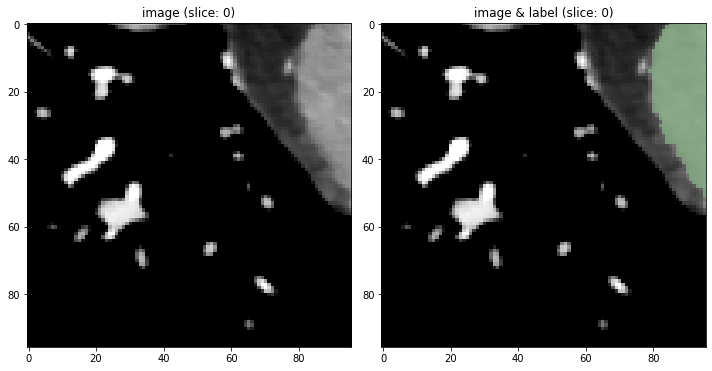

1
tensor([0., 1.])
(4, 1, 96, 96)
(4, 1, 96, 96)


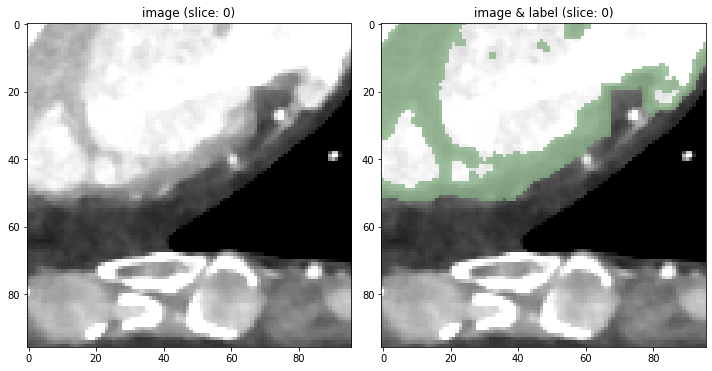

In [ ]:
# show train
for i, data in enumerate(loader[0]):
    print(i)
    print(data['label'].flatten().unique())
    print(data['label'].shape)
    print(data['image'].shape)
    show_img_lbl(
        data['image'][0][0],
        data['label'][0][0],
        0,
        num_classes=2, 
        axis_off=False,
        alpha=0.7,
        fig_size=(10, 20)
    )
    if i == 1:
      break

0
tensor([0., 1.])
(1, 1, 243, 243, 151)
(1, 1, 243, 243, 151)


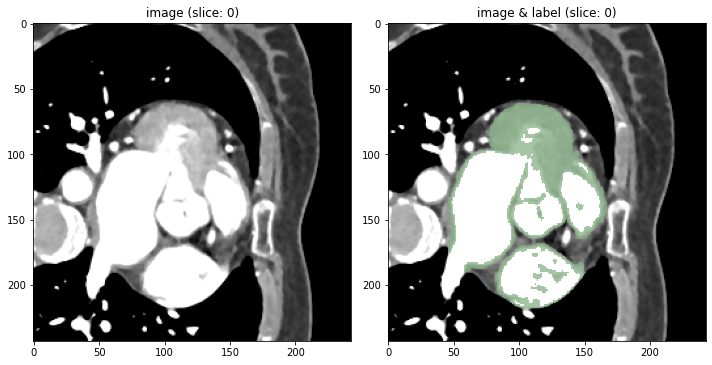

1
tensor([0., 1.])
(1, 1, 246, 246, 134)
(1, 1, 246, 246, 134)


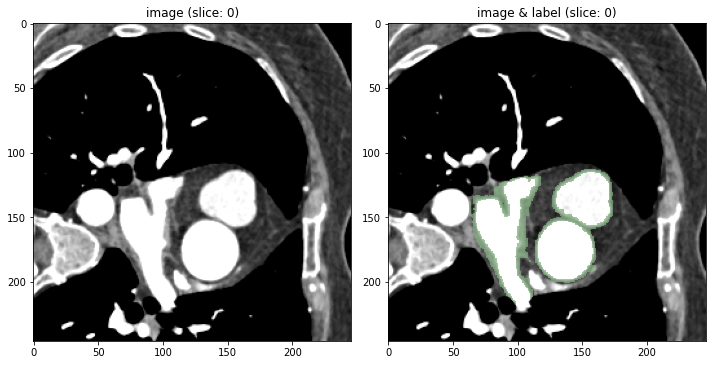

In [ ]:
# show test
for i, data in enumerate(loader[1]):
    print(i)
    print(data['label'].flatten().unique())
    print(data['label'].shape)
    print(data['image'].shape)
    show_img_lbl(
        data['image'][0][0][:,:,100],
        data['label'][0][0][:,:,100],
        0,
        num_classes=2, 
        axis_off=False,
        alpha=0.7,
        fig_size=(10, 20)
    )